# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 (Model 1) [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [2]:
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.3.1'

#### Load Image Data

In [3]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [49]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

base_model.summary()

Number of layers in the base model:  19
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooli

In [50]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(.4)(x)
x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=keras.regularizers.l2(l=0.3))(x)
x = tf.keras.layers.Dropout(.4)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=keras.regularizers.l2(l=0.3))(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)               

#### [5 points] Train Model

In [51]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE/10),
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=40,
                    validation_data=valid_batches)

Epoch 1/40
22/22 [==============================] - 7s 308ms/step - loss: 151.5618 - accuracy: 0.2778 - val_loss: 147.7494 - val_accuracy: 0.6111
Epoch 2/40
22/22 [==============================] - 6s 274ms/step - loss: 145.4193 - accuracy: 0.2963 - val_loss: 142.2655 - val_accuracy: 0.5000
Epoch 3/40
22/22 [==============================] - 6s 288ms/step - loss: 140.1026 - accuracy: 0.4028 - val_loss: 137.0128 - val_accuracy: 0.5556
Epoch 4/40
22/22 [==============================] - 6s 292ms/step - loss: 134.8022 - accuracy: 0.4074 - val_loss: 131.8941 - val_accuracy: 0.6296
Epoch 5/40
22/22 [==============================] - 6s 282ms/step - loss: 129.7278 - accuracy: 0.4306 - val_loss: 126.9202 - val_accuracy: 0.5741
Epoch 6/40
22/22 [==============================] - 6s 284ms/step - loss: 124.7632 - accuracy: 0.5417 - val_loss: 122.0277 - val_accuracy: 0.7037
Epoch 7/40
22/22 [==============================] - 6s 291ms/step - loss: 119.9855 - accuracy: 0.5324 - val_loss: 117.3285 -

#### [5 points] Plot Accuracy and Loss During Training

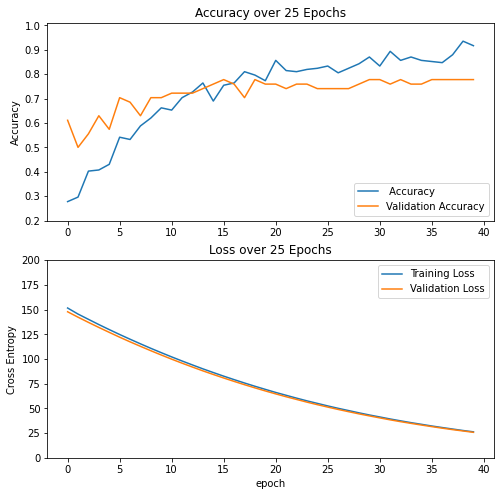

In [56]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label=' Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([.2,1.01])
plt.title('Accuracy over 25 Epochs')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,200])
plt.title('Loss over 25 Epochs')
plt.xlabel('epoch')
plt.show()

#### Testing Model

In [57]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 34ms/step - loss: 25.7542 - accuracy: 0.7500
Test loss: 25.75415802001953
Test accuracy: 0.75


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [58]:
from tensorflow.keras import models
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

In [63]:
intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_16').output)

tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")

intermediate_output = intermediate_layer_model.predict(tsne_data_generator)

reducedData = TSNE(n_components=2).fit_transform(intermediate_output)

class_array = tsne_data_generator.labels

tsne_data_generator.class_indices

Found 270 images belonging to 4 classes.


{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}

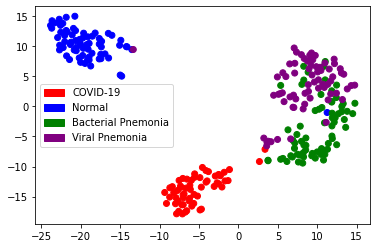

In [64]:
colormapping = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}
colors = [colormapping[i] for i in class_array]

plt.scatter(x = reducedData[:, 0], y = reducedData[:, 1], c = colors)

red_patch = mpatches.Patch(color='red', label='COVID-19')
blue_patch = mpatches.Patch(color='blue', label='Normal')
green_patch = mpatches.Patch(color='green', label='Bacterial Pnemonia')
purple_patch = mpatches.Patch(color='purple', label='Viral Pnemonia')
plt.legend(handles=[red_patch, blue_patch, green_patch, purple_patch])
plt.show()